In [1]:
import os
import random

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [12,12]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

In [4]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.random.choice(np.arange(106, 134), size=28,replace=False)

In [5]:
train_inds = labeled_scene_index[:20]#np.random.choice(labeled_scene_index,20,replace=False)#labeled_scene_index[:20]#
val_inds = labeled_scene_index[20:]#np.array([i for i in labeled_scene_index if i not in train_inds])#labeled_scene_index[20:]#

In [8]:
train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                            #torchvision.transforms.RandomAffine(degrees=0,translate=(0.1,0.1)),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                                                             std = [ 0.229, 0.224, 0.225 ])])
#(mean = [ 0.485, 0.456, 0.406 ],std = [ 0.229, 0.224, 0.225 ])])
val_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                                                                 std = [ 0.229, 0.224, 0.225 ])])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_inds,
                                  transform=train_transform,
                                  extra_info=True
                                 )

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_inds,
                                  transform=val_transform,
                                  extra_info=True
                                 )

trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1, shuffle=True, num_workers=2, collate_fn=collate_fn)

In [9]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([4, 6, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


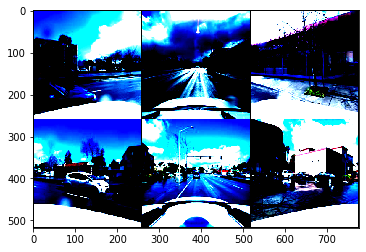

In [10]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))

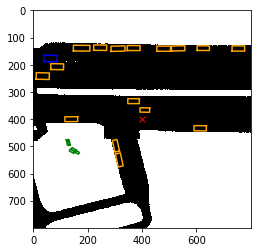

In [11]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])   

In [12]:
category_map = {'other_vehicle': 0, 'bicycle': 1, 'car': 2, 'pedestrian': 3, 'truck': 4,
                'bus': 5, 'motorcycle': 6, 'emergency_vehicle': 7, 'animal': 8}

## Model

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [14]:
class UNet(nn.Module):
    def ConvBlock(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, use_bias = False):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, 
                                        stride, padding, bias = use_bias),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU(True)
                             )
        return block
    
    def Bridge(self, in_channels, out_channels):
        bridge = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                               self.ConvBlock(out_channels, out_channels)
                              )
        return bridge
    
    def UpsampleBlock(self, in_channels, out_channels, use_bias=False):
        upsample = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=use_bias),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(True))
        return upsample
        
    def UpsampleConv(self, in_channels, out_channels):
        upsample_conv = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                                      self.ConvBlock(out_channels, out_channels))    
        return upsample_conv
        
        
    def __init__(self, num_classes, output_size, encoder='resnet18', pretrained = False, depth = 6):
        '''
        num_classes: Number of channels/classes for segmentation
        output_size: Final output size of the image (H*H)
        encoder: Supports resnet18, resnet 34 and resnet50 architectures
        pretrained: For loading a pretrained resnet model as encoder
        '''
        super(UNet,self).__init__()  
        self.depth = depth
        self.num_classes = num_classes
        self.output_size = output_size
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained) if encoder == "resnet50" else\
                            torchvision.models.resnet34(pretrained=pretrained) if encoder == "resnet34" else\
                            torchvision.models.resnet18(pretrained=pretrained)
        
        self.resnet_layers = list(self.resnet.children())
        self.n = 2048 if encoder == "resnet50" else 512
        
        self.input_block = nn.Sequential(*self.resnet_layers)[:3]
        self.input_block[0] = nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.input_pool = self.resnet_layers[3]
        self.down_blocks = nn.ModuleList([i for i in self.resnet_layers if isinstance(i, nn.Sequential)])

        self.bridge = self.Bridge(self.n, self.n)
        
        self.up_blocks = nn.ModuleList([self.UpsampleBlock(self.n,self.n//2)[0],
                                        self.UpsampleBlock(self.n//2,self.n//4)[0],
                                        self.UpsampleBlock(self.n//4,self.n//8)[0],
                                        self.UpsampleBlock(self.n//8,self.n//16)[0],
                                        self.UpsampleBlock(self.n//16,self.n//32)[0]])
        
        self.up_conv = nn.ModuleList([self.UpsampleConv(self.n,self.n//2),
                                      self.UpsampleConv(self.n//2,self.n//4),
                                      self.UpsampleConv(self.n//4,self.n//8),
                                      self.UpsampleConv(self.n//16 + 64,self.n//16),
                                      self.UpsampleConv(self.n//32 + 18,self.n//32)])
        
        self.final_upsample_1 = self.UpsampleBlock(self.n//32,self.n//64)
        self.final_upsample_2 = self.UpsampleBlock(self.n//64,self.num_classes)[0]
        
        self.final_pooling = nn.AdaptiveMaxPool2d(output_size=self.output_size)

    def forward(self, x):
        skip_conn = {"layer_0": x}
        x = self.input_block(x)
        skip_conn[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i != (self.depth - 1):
                skip_conn[f"layer_{i}"] = x
            
        x = self.bridge(x)

        #x = torch.sum(x,dim=0)
        #x = x.repeat((6,1,1,1))

        for i, block in enumerate(self.up_blocks):
            key = f"layer_{self.depth - i - 2}"            
            x = block(x)
            x = torch.cat([x, skip_conn[key]],1)
            x = self.up_conv[i](x)

        del skip_conn
        
        #x = torch.sum(x,dim=0)
        x = self.final_upsample_1(x)#.unsqueeze(0))
        x = self.final_upsample_2(x)
        x = self.final_pooling(x)
        x = x.view(-1,self.output_size,self.output_size)
        #x = torch.sigmoid(x)
        return x

In [15]:
model = UNet(num_classes=1, output_size=800, encoder="resnet34", pretrained = False).to(device)

In [16]:
lr = 5e-5
momentum = 0.9
num_epochs = 20

In [17]:
criterion = nn.BCEWithLogitsLoss()#pos_weight=torch.tensor(3)
#criterion = nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=lr,momentum=momentum,nesterov=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

### Training

In [18]:
def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

In [19]:
def dice_loss(pred,truth):
    return 1.0 - (2.0*torch.sum(pred*truth)+1.0)/(torch.sum(pred) + torch.sum(truth) + 1.0)

In [20]:
best_val_ts = 0
for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for i, (sample, target, road_image, _) in enumerate(tqdm(trainloader)):        
        
        sample, road_image = torch.stack(sample).view(-1,18,256,256).to(device), \
                                torch.stack(road_image).float().to(device)
        #target = torch.cat((target[0]['bounding_box'].view(8,-1),target[0]['category'].view(-1,1).double()),dim=-1).to(device)
        
        optimizer.zero_grad()
        out = model(sample)
        loss = 0.7*criterion(out, road_image) - 0.3*torch.log(compute_ts_road_map(torch.sigmoid(out), road_image))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        if (i+1)%200 == 0:
            print("Epoch: {} | Iter: {} | Train loss: {}".format(epoch+1, i+1, train_loss/(i+1)))
    
    model.eval()
    val_loss = 0
    val_ts = []
    with torch.no_grad():        
        for i, (sample, _, road_image, _) in enumerate(tqdm(valloader)):
            sample, road_image = torch.stack(sample).view(-1,18,256,256).to(device), \
                                torch.stack(road_image).float().to(device)
            out = model(sample)
            loss = 0.7*criterion(out, road_image) - 0.3*torch.log(compute_ts_road_map(torch.sigmoid(out), road_image))
            val_loss += loss.item()
            val_ts.append(compute_ts_road_map((torch.sigmoid(out)>0.5).float(), road_image).item())
        
    epoch_val_ts = np.mean(val_ts)
    print("Epoch: {} | Val loss: {} | Val TS: {}".format(epoch+1,val_loss/len(valloader), epoch_val_ts))
    if epoch_val_ts>best_val_ts:
        best_val_ts = epoch_val_ts
        print("Saving model...")
        torch.save(model.state_dict(),'unet_model.pth')
    #scheduler.step(epoch)

 32%|███▏      | 199/630 [00:57<01:55,  3.73it/s]

Epoch: 1 | Iter: 200 | Train loss: 0.7900945988297462


 64%|██████▎   | 401/630 [01:51<00:55,  4.10it/s]

Epoch: 1 | Iter: 400 | Train loss: 0.7285965485870838


 95%|█████████▌| 600/630 [02:52<00:07,  4.19it/s]

Epoch: 1 | Iter: 600 | Train loss: 0.6925228189428647


100%|██████████| 1008/1008 [01:25<00:00, 11.81it/s]


Epoch: 1 | Val loss: 0.5696007055895669 | Val TS: 0.6971585184986157
Saving model...


 32%|███▏      | 201/630 [00:37<01:13,  5.88it/s]

Epoch: 2 | Iter: 200 | Train loss: 0.5995368653535843


 64%|██████▎   | 401/630 [01:13<00:39,  5.86it/s]

Epoch: 2 | Iter: 400 | Train loss: 0.5897046311199665


 95%|█████████▌| 601/630 [01:50<00:04,  6.62it/s]

Epoch: 2 | Iter: 600 | Train loss: 0.5855425734321277


100%|██████████| 1008/1008 [00:41<00:00, 24.57it/s]


Epoch: 2 | Val loss: 0.5462869176907199 | Val TS: 0.6995301552057739
Saving model...


 32%|███▏      | 201/630 [00:37<01:14,  5.76it/s]

Epoch: 3 | Iter: 200 | Train loss: 0.5604058787226677


 63%|██████▎   | 400/630 [01:13<00:44,  5.16it/s]

Epoch: 3 | Iter: 400 | Train loss: 0.5524646131694317


 95%|█████████▌| 600/630 [01:50<00:04,  6.27it/s]

Epoch: 3 | Iter: 600 | Train loss: 0.5462370803952217


100%|██████████| 1008/1008 [00:41<00:00, 24.18it/s]


Epoch: 3 | Val loss: 0.5251051507417172 | Val TS: 0.7073318594327521
Saving model...


 32%|███▏      | 200/630 [00:36<01:15,  5.71it/s]

Epoch: 4 | Iter: 200 | Train loss: 0.5211396954953671


 64%|██████▎   | 401/630 [01:13<00:41,  5.49it/s]

Epoch: 4 | Iter: 400 | Train loss: 0.5147638353705406


 95%|█████████▌| 600/630 [01:49<00:05,  5.48it/s]

Epoch: 4 | Iter: 600 | Train loss: 0.5095303949713706


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 4 | Val loss: 0.5070537279640871 | Val TS: 0.7010332287422248


 32%|███▏      | 201/630 [00:36<01:22,  5.21it/s]

Epoch: 5 | Iter: 200 | Train loss: 0.47585630536079404


 64%|██████▎   | 401/630 [01:13<00:41,  5.48it/s]

Epoch: 5 | Iter: 400 | Train loss: 0.47056177124381066


 95%|█████████▌| 601/630 [01:50<00:05,  5.21it/s]

Epoch: 5 | Iter: 600 | Train loss: 0.46435812920331954


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 5 | Val loss: 0.4868603354053838 | Val TS: 0.701881124061488


 32%|███▏      | 200/630 [00:36<01:19,  5.40it/s]

Epoch: 6 | Iter: 200 | Train loss: 0.43562180891633034


 63%|██████▎   | 400/630 [01:12<00:41,  5.53it/s]

Epoch: 6 | Iter: 400 | Train loss: 0.4281332477927208


 95%|█████████▌| 600/630 [01:49<00:05,  5.42it/s]

Epoch: 6 | Iter: 600 | Train loss: 0.42102781663338346


100%|██████████| 1008/1008 [00:42<00:00, 23.62it/s]


Epoch: 6 | Val loss: 0.4709253713843368 | Val TS: 0.7095981503703764
Saving model...


 32%|███▏      | 200/630 [00:36<01:18,  5.45it/s]

Epoch: 7 | Iter: 200 | Train loss: 0.3892158909142017


 63%|██████▎   | 400/630 [01:13<00:37,  6.06it/s]

Epoch: 7 | Iter: 400 | Train loss: 0.3831993830949068


 95%|█████████▌| 600/630 [01:50<00:05,  5.44it/s]

Epoch: 7 | Iter: 600 | Train loss: 0.38078043684363366


100%|██████████| 1008/1008 [00:42<00:00, 23.98it/s]


Epoch: 7 | Val loss: 0.452510683634688 | Val TS: 0.7215129064602984
Saving model...


 32%|███▏      | 200/630 [00:36<01:19,  5.43it/s]

Epoch: 8 | Iter: 200 | Train loss: 0.35938311710953713


 63%|██████▎   | 400/630 [01:13<00:40,  5.71it/s]

Epoch: 8 | Iter: 400 | Train loss: 0.35274331998080016


 95%|█████████▌| 601/630 [01:49<00:04,  6.02it/s]

Epoch: 8 | Iter: 600 | Train loss: 0.3460769251237313


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 8 | Val loss: 0.44471844140854144 | Val TS: 0.7159859515903961


 32%|███▏      | 201/630 [00:37<01:06,  6.42it/s]

Epoch: 9 | Iter: 200 | Train loss: 0.32113500729203226


 63%|██████▎   | 400/630 [01:13<00:42,  5.44it/s]

Epoch: 9 | Iter: 400 | Train loss: 0.3176923164725304


 95%|█████████▌| 600/630 [01:49<00:04,  6.01it/s]

Epoch: 9 | Iter: 600 | Train loss: 0.3123708565036456


100%|██████████| 1008/1008 [00:48<00:00, 20.90it/s]


Epoch: 9 | Val loss: 0.4261482995417383 | Val TS: 0.727599202610907
Saving model...


 32%|███▏      | 201/630 [00:37<01:15,  5.72it/s]

Epoch: 10 | Iter: 200 | Train loss: 0.28639519020915033


 64%|██████▎   | 401/630 [01:13<00:36,  6.29it/s]

Epoch: 10 | Iter: 400 | Train loss: 0.28605484891682864


 95%|█████████▌| 601/630 [01:50<00:05,  5.60it/s]

Epoch: 10 | Iter: 600 | Train loss: 0.2830836696177721


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 10 | Val loss: 0.4257318612690719 | Val TS: 0.7184359690558816


 32%|███▏      | 200/630 [00:37<01:13,  5.89it/s]

Epoch: 11 | Iter: 200 | Train loss: 0.2614291045814753


 63%|██████▎   | 400/630 [01:14<00:41,  5.53it/s]

Epoch: 11 | Iter: 400 | Train loss: 0.2596526492387056


 95%|█████████▌| 601/630 [01:51<00:06,  4.74it/s]

Epoch: 11 | Iter: 600 | Train loss: 0.25708727071682613


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 11 | Val loss: 0.4140561699335064 | Val TS: 0.7246371931322511


 32%|███▏      | 201/630 [00:37<01:08,  6.23it/s]

Epoch: 12 | Iter: 200 | Train loss: 0.23789565898478032


 64%|██████▎   | 401/630 [01:14<00:41,  5.56it/s]

Epoch: 12 | Iter: 400 | Train loss: 0.23693405095487832


 95%|█████████▌| 600/630 [01:50<00:04,  6.58it/s]

Epoch: 12 | Iter: 600 | Train loss: 0.2328813108553489


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 12 | Val loss: 0.40429216088165365 | Val TS: 0.7275637855221119


 32%|███▏      | 201/630 [00:36<01:10,  6.06it/s]

Epoch: 13 | Iter: 200 | Train loss: 0.21678365357220172


 64%|██████▎   | 401/630 [01:12<00:41,  5.49it/s]

Epoch: 13 | Iter: 400 | Train loss: 0.21354066364467145


 95%|█████████▌| 601/630 [01:49<00:04,  5.84it/s]

Epoch: 13 | Iter: 600 | Train loss: 0.21061381161212922


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 13 | Val loss: 0.4059853246435523 | Val TS: 0.7203278025050485


 32%|███▏      | 201/630 [00:37<01:21,  5.26it/s]

Epoch: 14 | Iter: 200 | Train loss: 0.19420936338603498


 64%|██████▎   | 401/630 [01:12<00:42,  5.34it/s]

Epoch: 14 | Iter: 400 | Train loss: 0.19325816366821527


 95%|█████████▌| 601/630 [01:48<00:05,  5.57it/s]

Epoch: 14 | Iter: 600 | Train loss: 0.1912304590642452


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 14 | Val loss: 0.4074983827710625 | Val TS: 0.7220618922026858


 32%|███▏      | 201/630 [00:36<01:17,  5.55it/s]

Epoch: 15 | Iter: 200 | Train loss: 0.17936166834086179


 63%|██████▎   | 400/630 [01:13<00:37,  6.10it/s]

Epoch: 15 | Iter: 400 | Train loss: 0.17592594139277934


 95%|█████████▌| 600/630 [01:49<00:05,  5.76it/s]

Epoch: 15 | Iter: 600 | Train loss: 0.17466205903639395


100%|██████████| 1008/1008 [00:43<00:00, 23.34it/s]


Epoch: 15 | Val loss: 0.3903922223973842 | Val TS: 0.7301953416613359
Saving model...


 32%|███▏      | 200/630 [00:37<01:13,  5.86it/s]

Epoch: 16 | Iter: 200 | Train loss: 0.16360035430639983


 63%|██████▎   | 400/630 [01:14<00:41,  5.52it/s]

Epoch: 16 | Iter: 400 | Train loss: 0.15939140679314734


 95%|█████████▌| 600/630 [01:51<00:05,  5.87it/s]

Epoch: 16 | Iter: 600 | Train loss: 0.15794704906642437


100%|██████████| 1008/1008 [00:48<00:00, 20.98it/s]


Epoch: 16 | Val loss: 0.3893623414286782 | Val TS: 0.7319680765152924
Saving model...


 32%|███▏      | 200/630 [00:37<01:13,  5.86it/s]

Epoch: 17 | Iter: 200 | Train loss: 0.14726080726832153


 64%|██████▎   | 401/630 [01:13<00:40,  5.60it/s]

Epoch: 17 | Iter: 400 | Train loss: 0.14520075343549252


 95%|█████████▌| 601/630 [01:50<00:04,  6.34it/s]

Epoch: 17 | Iter: 600 | Train loss: 0.14314063474535943


100%|██████████| 1008/1008 [00:43<00:00, 23.28it/s]


Epoch: 17 | Val loss: 0.39221242016979624 | Val TS: 0.7322629983758643
Saving model...


 32%|███▏      | 200/630 [00:36<01:14,  5.74it/s]

Epoch: 18 | Iter: 200 | Train loss: 0.13299295868724584


 64%|██████▎   | 401/630 [01:12<00:40,  5.72it/s]

Epoch: 18 | Iter: 400 | Train loss: 0.13065353251993655


 95%|█████████▌| 601/630 [01:48<00:04,  5.82it/s]

Epoch: 18 | Iter: 600 | Train loss: 0.1301422783235709


  0%|          | 0/630 [00:00<?, ?it/s]

Epoch: 18 | Val loss: 0.3922497401501806 | Val TS: 0.729787916240711


 32%|███▏      | 201/630 [00:36<01:13,  5.87it/s]

Epoch: 19 | Iter: 200 | Train loss: 0.12306641243398189


 64%|██████▎   | 401/630 [01:12<00:40,  5.71it/s]

Epoch: 19 | Iter: 400 | Train loss: 0.12127112124115229


 95%|█████████▌| 600/630 [01:49<00:05,  5.65it/s]

Epoch: 19 | Iter: 600 | Train loss: 0.11914936707665523


100%|██████████| 1008/1008 [00:40<00:00, 24.86it/s]


Epoch: 19 | Val loss: 0.39008459635818055 | Val TS: 0.7392835184222176
Saving model...


 32%|███▏      | 201/630 [00:36<01:17,  5.57it/s]

Epoch: 20 | Iter: 200 | Train loss: 0.11138400506228209


 64%|██████▎   | 401/630 [01:12<00:42,  5.40it/s]

Epoch: 20 | Iter: 400 | Train loss: 0.1088433190062642


 95%|█████████▌| 600/630 [01:49<00:05,  5.80it/s]

Epoch: 20 | Iter: 600 | Train loss: 0.10852461468428373


100%|██████████| 1008/1008 [00:40<00:00, 24.79it/s]

Epoch: 20 | Val loss: 0.38864979967622765 | Val TS: 0.7344193315458676


In [21]:
model.load_state_dict(torch.load('unet_model.pth'))

<All keys matched successfully>

### Visualize predictions

In [96]:
sample, target, road_image, extra = iter(trainloader).next()
sample, road_image = torch.stack(sample).view(-1,18,256,256).to(device), \
                                torch.stack(road_image).float().to(device)
out = model(sample.to(device))

Text(0.5, 1.0, 'Ground Truth')

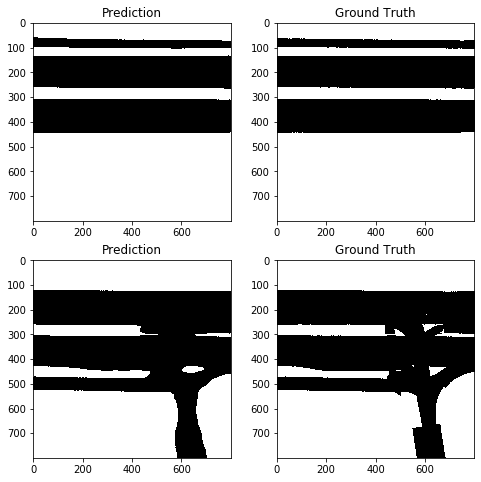

In [97]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(2,2,1)
plt.imshow((torch.sigmoid(out[0])>0.5).float().detach().cpu().numpy(),cmap='binary')
plt.title("Prediction")

fig.add_subplot(2,2,2)
plt.imshow(road_image[0].cpu().numpy(),cmap='binary')
plt.title("Ground Truth")

fig.add_subplot(2,2,3)
plt.imshow((torch.sigmoid(out[1])>0.5).float().detach().cpu().numpy(),cmap='binary')
plt.title("Prediction")

fig.add_subplot(2,2,4)
plt.imshow(road_image[1].cpu().numpy(),cmap='binary')
plt.title("Ground Truth")

In [128]:
sample, target, road_image, extra = iter(valloader).next()
sample, road_image = torch.stack(sample).view(-1,18,256,256).to(device), \
                                torch.stack(road_image).float().to(device)
out = model(sample.to(device))

Text(0.5, 1.0, 'Ground Truth')

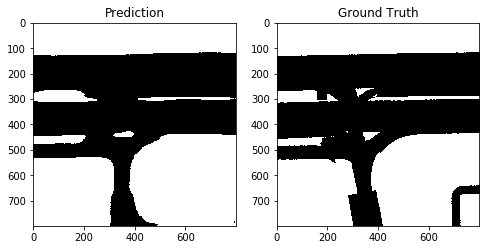

In [129]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow((torch.sigmoid(out[0])>0.5).float().detach().cpu().numpy(),cmap='binary')
plt.title("Prediction")

fig.add_subplot(1,2,2)
plt.imshow(road_image[0].cpu().numpy(),cmap='binary')
plt.title("Ground Truth")